In [13]:
#Loading all librairies
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import *

Using TensorFlow backend.


In [65]:
#Reading file
log_file = pd.read_excel("Lagos.xlsx", parse_dates=['DATE &  TIME'])

In [66]:
#Selecting only the columns we need
log_file  = log_file[['DATE &  TIME', 'SOLAR RADIATION', 'AIR TEMP', 'RELATIVE HUMIDITY', 'PRESSURE']]

In [67]:
log_all = log_file[3:]

In [68]:
#Removing all rows with empty cells
log_day_l = log_all.loc[log_all['AIR TEMP'] == ' '].index
log_all.drop(log_day_l, inplace=True)

C:\Users\aristidemima\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
log_all[227:228]

,DATE & TIME,SOLAR RADIATION,AIR TEMP,RELATIVE HUMIDITY,PRESSURE
231,2007-10-30 07:30:00,29.91,25.92,90.6,1000


In [70]:
#Removing all rows with NAN values
for col in log_all.columns:
    if col == 'DATE &  TIME':
        continue
    log_day_l = log_all.loc[log_all[col] == 'NAN'].index
    log_all.drop(log_day_l, inplace=True)
    log_all[col] = pd.to_numeric(log_all[col])
    
log_all['DATE &  TIME'] = log_all['DATE &  TIME'].astype('datetime64[ns]')
log_all = log_all.set_index('DATE &  TIME')

C:\Users\aristidemima\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\aristidemima\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
#Averaging datas
log_hour = log_all.resample('H').mean()
log_day = log_all.resample('D').mean()
log_hour = log_hour.dropna()
log_day = log_day.dropna()

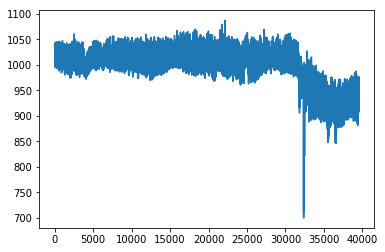

In [72]:
plt.plot(log_hour.values[:,3])

In [73]:
#Scaling and storing scaler parameters for day and hour
from pickle import dump
scaler = MinMaxScaler((0,1))
log_datas = scaler.fit_transform(log_hour.values)
dump(scaler, open('Lagos-scaler-hour.pkl', 'wb'))

scaler = MinMaxScaler((0,1))
log_datas = scaler.fit_transform(log_day.values)
dump(scaler, open('Lagos-scaler-day.pkl', 'wb'))

 <h1 style="color:blue">#Hourly Forecasting#</h1>

In [99]:
#construct the features and labels sets:
features = []
labels = []
for i in range(3, log_datas.shape[0]-4):
    features.append(log_datas[i-3:i,:])
    labels.append(log_datas[i,:])

In [100]:
#Converting list features ans labels to array
features , labels = array(features), array(labels)

In [101]:
# Divide datas for training and testing
#Reshape the X_train in lstm format
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))

In [102]:
X_train.shape

(29672, 3, 4)

In [103]:
log_hour.values.shape, log_day.values.shape

((39570, 4), (1756, 4))

In [104]:
#Building and fiting Hourly LSTM Model
model = Sequential()
model.add(LSTM(units=200,  activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.02))
model.add(LSTM(units=150, activation='relu', return_sequences=True))
model.add(Dropout(0.02))
model.add(LSTM(units=150, activation='relu', return_sequences=True))
model.add(Dropout(0.02))
model.add(LSTM(units=150, activation='relu', return_sequences=True))
model.add(Dropout(0.02))
model.add(LSTM(units=150, activation='relu', return_sequences=False))
model.add(Dropout(0.02))
model.add(Dense(4))
model.compile(loss='mse', optimizer='adam')
    
history = model.fit(X_train, y_train, validation_split=0.25, shuffle=False, epochs = 200, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Train on 22254 samples, validate on 7418 samples
Epoch 1/200
22254/22254 [==============================] - 52s 2ms/step - loss: 0.0226 - val_loss: 0.0033
Epoch 2/200
22254/22254 [==============================] - 40s 2ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 3/200
22254/22254 [==============================] - 40s 2ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/200
22254/22254 [==============================] - 43s 2ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 5/200
22254/22254 [==============================] - 43s 2ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 6/200
22254/22254 [==============================] - 42s 2ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/200
22254/22254 [==============================] - 42s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 8/200
22254/22254 [==============================] - 43s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/200
22254/22254 [==============================] - 42s 2ms/step - loss: 0.0024 - val_loss: 0.00

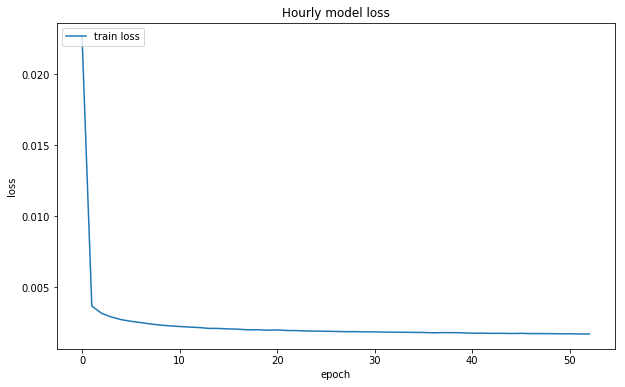

In [105]:
#Learning curve
fig  = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.title('Hourly model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

fig.savefig("train_hour_Lagos.png")

In [106]:
#Compute predictions and evaluate RMSE (Reverse and normal form)
import math
predictions = model.predict(X_test)
predictions_t = model.predict(X_train)
predictions = scaler.inverse_transform(predictions)
predictions_t = scaler.inverse_transform(predictions_t)
train_score = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train), predictions_t))
test_score = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test), predictions))

print('Train Score: %.2f RMSE' % (train_score)), print('Test Score: %.2f RMSE' % (test_score))

Train Score: 31.86 RMSE
Test Score: 32.60 RMSE


(None, None)

In [107]:
pred_train= model.predict(X_train)
pred= model.predict(X_test)
np.sqrt(mean_squared_error(y_train,pred_train)), np.sqrt(mean_squared_error(y_test,pred))

(0.03995412647456152, 0.04086014981537475)

In [108]:
model.save('model_Lagos_hour.h5')

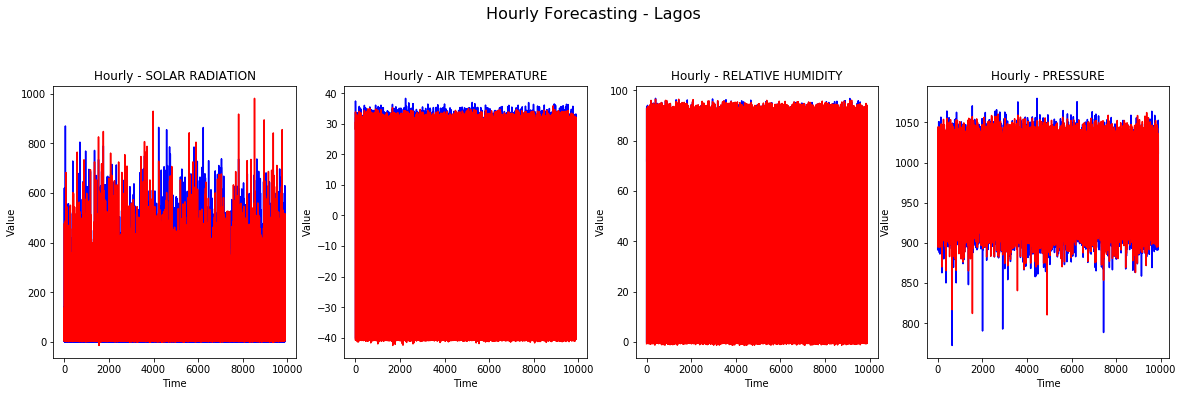

In [109]:
#Ploting hourly prediction for each parameter 
f, ax= plt.subplots(1, 4)
parameters = ['SOLAR RADIATION', 'AIR TEMPERATURE', 'RELATIVE HUMIDITY', 'PRESSURE']
digits = [111, 112, 113, 114]
for i in range(4):
    ax[i].plot(scaler.inverse_transform(y_test)[:,i], color='blue')
    ax[i].plot(predictions[:,i] , color='red')
    ax[i].set_title('Hourly - ' + parameters[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
f.set_size_inches(20, 5)
f.suptitle("Hourly Forecasting - Lagos", size=16, y=1.10)
f.savefig("forecast_hour_Lagos.png")

In [110]:
model.evaluate(X_test, y_test)

9891/9891 [==============================] - 7s 747us/step


0.0016695518446226546

 <h1 style="color:blue">#Daily Forecasting#</h1>

In [111]:
#Scaling day datas
scaler_day = MinMaxScaler()
log_datas_day = scaler_day.fit_transform(log_day.values)

In [112]:
#construct the features and labels sets:
features_day = []
labels_day = []
for i in range(3, log_datas_day.shape[0]-4):
    features_day.append(log_datas_day[i-3:i,:])
    labels_day.append(log_datas_day[i,:])

In [113]:
#Converting list features ans labels to array
features_day , labels_day = array(features_day), array(labels_day)
# Divide datas for training and testing
#Reshape the X_train in lstm format
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(features_day, labels_day, test_size=0.25, random_state=42) 
X_train_day = np.reshape(X_train_day, (X_train_day.shape[0], X_train_day.shape[1], 4))

In [114]:
#Building and fiting daily LSTM Model
model = Sequential()
model.add(LSTM(units=100,  activation='relu', return_sequences=True, input_shape=(X_train_day.shape[1], 4)))
model.add(Dropout(0.01))
model.add(LSTM(units=90, activation='relu', return_sequences=True))
model.add(Dropout(0.01))
model.add(LSTM(units=90, activation='relu', return_sequences=False))
model.add(Dropout(0.01))
model.add(Dense(4))
model.compile(loss='mse', optimizer='adam')
    
history = model.fit(X_train_day, y_train_day, validation_split=0.25, shuffle=False, epochs = 200, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Train on 983 samples, validate on 328 samples
Epoch 1/200
983/983 [==============================] - 27s 27ms/step - loss: 0.3003 - val_loss: 0.0745
Epoch 2/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0250 - val_loss: 0.0177
Epoch 3/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 4/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 5/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 6/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 7/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 8/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/200
983/983 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 10/200
983/983 [=====================

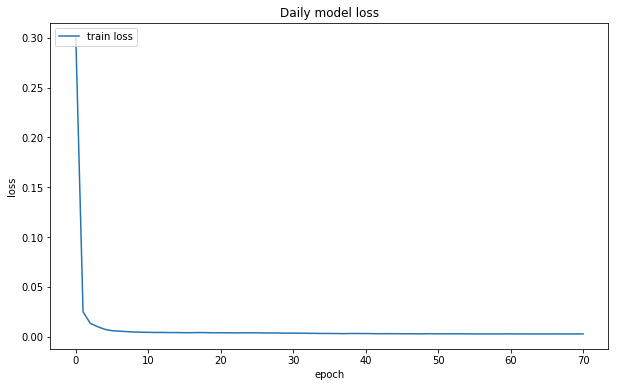

In [115]:
#Ploting the learning curve for daily model
f = plt.figure(figsize=(10,6))

plt.plot(history.history['loss'])
plt.title('Daily model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

f.savefig("train_day_Lagos.png")

In [116]:
#Computing RMSE scores and reverse those scores
import math
predictions = model.predict(X_test_day)
predictions_t = model.predict(X_train_day)
predictions = scaler_day.inverse_transform(predictions)
predictions_t = scaler_day.inverse_transform(predictions_t)
train_score = math.sqrt(mean_squared_error(scaler_day.inverse_transform(y_train_day), predictions_t))
test_score = math.sqrt(mean_squared_error(scaler_day.inverse_transform(y_test_day), predictions))

print('Train Score: %.2f RMSE' % (train_score)), print('Test Score: %.2f RMSE' % (test_score))

Train Score: 17.74 RMSE
Test Score: 18.44 RMSE


(None, None)

In [117]:
#Ploting RMSE score without reversing it
pred_train= model.predict(X_train_day)
pred= model.predict(X_test_day)
np.sqrt(mean_squared_error(y_train_day,pred_train)), np.sqrt(mean_squared_error(y_test_day,pred))

(0.050995950058780694, 0.049282051633031274)

In [118]:
model.save('model_Lagos_day.h5')

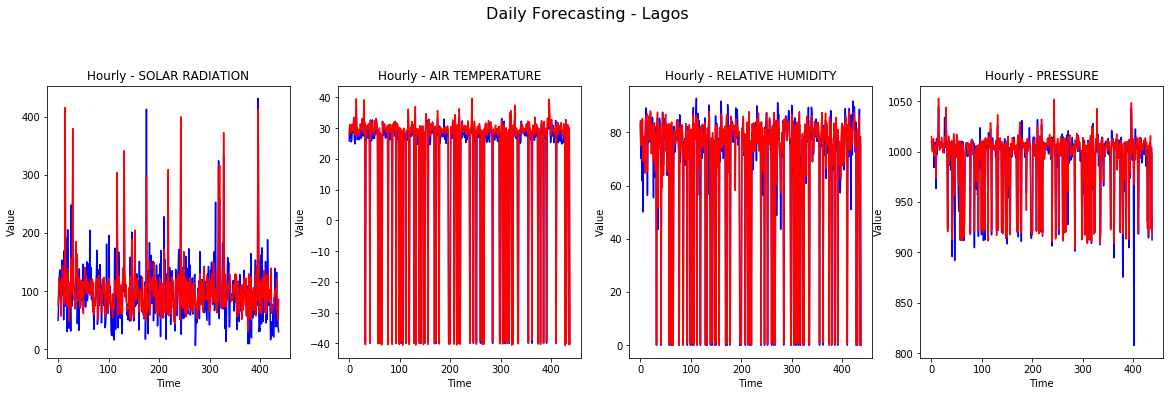

In [119]:
#Ploting  daily prediction for each parameter 
f, ax= plt.subplots(1, 4)
parameters = ['SOLAR RADIATION', 'AIR TEMPERATURE', 'RELATIVE HUMIDITY', 'PRESSURE']
for i in range(4):
    ax[i].plot(scaler_day.inverse_transform(y_test_day)[:,i], color='blue')
    ax[i].plot(predictions[:,i] , color='red')
    ax[i].set_title('Hourly - ' + parameters[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
f.set_size_inches(20, 5)
f.suptitle("Daily Forecasting - Lagos", size=16, y=1.10)
f.savefig("forecast_day_Lagos.png")